In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import chart_studio.plotly as ply

# prophet by Facebook
from fbprophet import Prophet

# Input data files are available in the "../input/" directory.

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/quickservicerestaurantinventorydata/historical_sales.csv
/kaggle/input/quickservicerestaurantinventorydata/supplier_details.csv
/kaggle/input/quickservicerestaurantinventorydata/historical_order_summary.csv
/kaggle/input/quickservicerestaurantinventorydata/recipe.csv
/kaggle/input/quickservicerestaurantinventorydata/key_cost_items.csv


In [3]:
recipe = pd.read_csv('../input/quickservicerestaurantinventorydata/recipe.csv')
costs = pd.read_csv('../input/quickservicerestaurantinventorydata/key_cost_items.csv')
sales = pd.read_csv('../input/quickservicerestaurantinventorydata/historical_sales.csv', thousands=',')
suppliers = pd.read_csv('../input/quickservicerestaurantinventorydata/supplier_details.csv')
orders = pd.read_csv('../input/quickservicerestaurantinventorydata/historical_order_summary.csv')

In [4]:
sales['Week Starting'] = pd.to_datetime(sales['Week Starting'], infer_datetime_format=True, dayfirst=True)
sales.columns = ['week_starting', 'units_sold']
sales.sort_values(by='week_starting', inplace=True)
sales.head()

,week_starting,units_sold
0,2012-01-01,85308
1,2012-01-08,41000
2,2012-01-15,94323
3,2012-01-22,120252
4,2012-01-29,82902


In [5]:
fig = px.line(sales, x='week_starting', y='units_sold')
fig.show()

Roughly constant demand ignoring seasonal, cyclical and random components

In [6]:
# Handling outliers
# https://facebook.github.io/prophet/docs/outliers.html
sales['units_sold'][sales['units_sold']<60000] = 65000

In [7]:
fig = px.line(sales, x='week_starting', y='units_sold')
fig.show()

We can use an additive model when it seems that the trend is more linear and the seasonality and trend components seem to be constant over time (e.g. every time period, we add 100 units). A multiplicative model is more appropriate when we are increasing (or decreasing) at a non-linear rate (e.g. we double every time period)

In [8]:
dt_index = pd.DatetimeIndex(sales.week_starting, freq='infer')
sales_date_index = sales.set_index(dt_index)
sales_date_index.drop(columns=['week_starting'], inplace=True)
sales_date_index.sort_index(inplace=True)
sales_date_index.head()

,units_sold
week_starting,
2012-01-01,85308
2012-01-08,65000
2012-01-15,94323
2012-01-22,120252
2012-01-29,82902


In [9]:
# train test split
train_size = int(len(sales_date_index) * 0.9)
train, test = sales_date_index[0:train_size], sales_date_index[train_size:len(sales_date_index)]

In [10]:
print(len(sales_date_index))
print(len(train))
print(len(test))

74
66
8


#### TREND & TREND PARAMETERS
business insights can be applied: trend changepoints can be manually fed  
e.g. jump of sales during holidays, increased sales due to decrease costs  
As the number of changepoints allowed is increased the fit becomes more flexible.  
problems with trend component: Overfitting and Underfitting  
solution: changepoint_prior_scale parameter (to adjust trend flexibility).  
Higher changepoint_prior_scale value will fit a more flexible curve to the time series.  

**growth**:	linear’ or ‘logistic’ to specify a linear or logistic trend  
**changepoints**:	List of dates at which to include potential changepoints (automatic if not specified)  
**n_changepoints**:	If changepoints in not supplied, you may provide the number of changepoints to be   automatically included  
**changepoint_prior_scale**:	Parameter for changing flexibility of automatic changepoint selection

#### SEASONALITY
To fit and forecast the effects of seasonality, prophet relies on fourier series  
The **fourier order N** is an important parameter to set here  
N that defines whether high frequency changes are allowed to be modelled.  
For a time series, if the user believes the high frequency components are just noise  
and should not be considered for modelling, he/she could set the values of N from to a lower value.  
If not, N can be tuned to a higher value and set using the forecast accuracy.
https://facebook.github.io/prophet/docs/multiplicative_seasonality.html

#### HOLIDAYS & EVENTS
Prophet allows the analyst to provide a custom list of  past and future events.  
A window around such days are considered separately and additional parameters are fitted  
to model the effect of holidays and events.  

#### SEASONALITY & HOLIDAY PARAMETERS
**yearly_seasonality**	Fit yearly seasonality  
**weekly_seasonality**	Fit weekly seasonality  
**daily_seasonality**	Fit daily seasonality  
**holidays**	Feed dataframe containing holiday name and date  
**seasonality_prior_scale**	Parameter for changing strength of seasonality model  
**holiday_prior_scale**	Parameter for changing strength of holiday model  
  
yearly_seasonality, weekly_seasonality & daily_seasonality can take values as True, False and no. of fourier terms which was discussed in the last section. If the value is True, default number of fourier terms (10) are taken. Prior scales are defined to tell the model how strongly it needs to consider the seasonal/holiday components while fitting and forecasting.

In [11]:
# Carrying capacity, forecasting growth and saturating minimum
# We are not using these parameters in our case

In [12]:
# Prophet requires the variable names in the time series to be:
# y – Target
# ds – Datetime
train['ds'] = train.index
train['y'] = train.units_sold
train.drop(['units_sold'],axis = 1, inplace = True)

Uncertainty 

Data with Gap: only make predictions for the time windows for which there are historical data

In [13]:
# confidence interval
model1=Prophet(interval_width=0.95, yearly_seasonality=True, weekly_seasonality=False) # by default is 80%

In [14]:
model1.fit(train)

In [15]:
future = model1.make_future_dataframe(periods=8, freq='W')
future

,ds
0,2012-01-01
1,2012-01-08
2,2012-01-15
3,2012-01-22
4,2012-01-29
...,...
69,2013-04-28
70,2013-05-05
71,2013-05-12
72,2013-05-19


In [16]:
forecast = model1.predict(future)
forecast[['yhat', 'yhat_lower', 'yhat_upper']]

,yhat,yhat_lower,yhat_upper
0,83077.982433,67321.859138,99849.660742
1,89462.462912,73349.158161,105385.762913
2,97280.829026,82387.079687,113820.328772
3,100566.474745,85821.963224,116027.320676
4,96574.605303,80768.495680,112634.699583
...,...,...,...
69,79711.394861,62891.280821,96229.637334
70,78607.231029,63121.246223,92872.416710
71,80055.013828,64407.239712,96302.461693
72,81584.201869,66073.146732,97080.312109


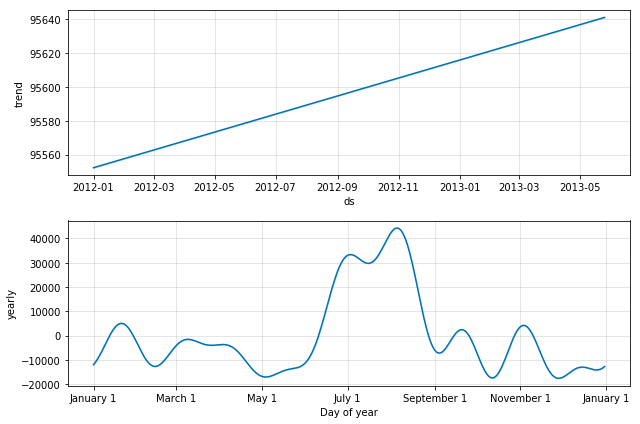

In [17]:
components = model1.plot_components(forecast)
components.show()

In [18]:
# Calculate MAPE (mean absolute percentage error on predicted values)
test['units_sold']

week_starting
2013-04-07    92142
2013-04-14    91147
2013-04-21    65495
2013-04-28    65232
2013-05-05    88392
2013-05-12    80976
2013-05-19    89849
2013-05-26    96005
Freq: W-SUN, Name: units_sold, dtype: int64

In [19]:
# Calculate MAPE (Mean absolute percentage error)
forecast.set_index('ds', inplace=True) # Uncomment this while running
temp = (test['units_sold'] - forecast.loc['2013-04-07':,'yhat'])
print("MAPE: ",(temp.abs()/test['units_sold']).mean() * 100, "%")

MAPE:  11.124771695593386 %


In [20]:
forecast.loc['2013-04-07':,'yhat']

ds
2013-04-07    91623.086883
2013-04-14    88874.263319
2013-04-21    83938.551664
2013-04-28    79711.394861
2013-05-05    78607.231029
2013-05-12    80055.013828
2013-05-19    81584.201869
2013-05-26    82392.578408
Name: yhat, dtype: float64

In [21]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=sales_date_index.index, y=sales_date_index['units_sold'], name="units_sold",
                         line_color='deepskyblue'))

fig.add_trace(go.Scatter(x=forecast.index, y=forecast['yhat'], name="predicted",
                         line_color='indianred'))

fig.add_trace(go.Scatter(name='Upper Bound',x=sales_date_index.index, y=forecast['yhat_upper'],
                         mode='lines', marker=dict(color="#444"), line=dict(width=0), fillcolor='rgba(68, 68, 68, 0.3)',
                         fill='tonexty'))

fig.add_trace(go.Scatter(name='Lower Bound',x=sales_date_index.index, y=forecast['yhat_lower'],
                         mode='lines', marker=dict(color="#444"), line=dict(width=0), fillcolor='rgba(68, 68, 68, 0.3)',
                         fill='tonexty'))

fig.update_layout(title_text='Actual & Forecasted Time-Series with Rangeslider',
                  xaxis_rangeslider_visible=True)
fig.show()

In [22]:
# GRID SEARCH FOR BEST PARAMETERS
from sklearn.model_selection import ParameterGrid
params_grid = {'yearly_seasonality':[5,10],
               'changepoint_prior_scale':[0.01,0.05, 0.1]}
grid = ParameterGrid(params_grid)
print([p for p in grid])

[{'changepoint_prior_scale': 0.01, 'yearly_seasonality': 5}, {'changepoint_prior_scale': 0.01, 'yearly_seasonality': 10}, {'changepoint_prior_scale': 0.05, 'yearly_seasonality': 5}, {'changepoint_prior_scale': 0.05, 'yearly_seasonality': 10}, {'changepoint_prior_scale': 0.1, 'yearly_seasonality': 5}, {'changepoint_prior_scale': 0.1, 'yearly_seasonality': 10}]


In [23]:
for p in grid:
    m =Prophet(**p)
    m.fit(train)
    future_dates = m.make_future_dataframe(periods=8, freq='W')
    future_predict = m.predict(future_dates)
    future_predict.set_index('ds', inplace=True)
    # Calculate MAPE (Mean absolute percentage error)
    temp = (test['units_sold'] - future_predict.loc['2013-04-07':,'yhat'])
    print("MAPE: ",(temp.abs()/test['units_sold']).mean() * 100, "% ", p)

MAPE:  12.230122529576768 %  {'changepoint_prior_scale': 0.01, 'yearly_seasonality': 5}
MAPE:  11.159261244673415 %  {'changepoint_prior_scale': 0.01, 'yearly_seasonality': 10}
MAPE:  12.219194808484511 %  {'changepoint_prior_scale': 0.05, 'yearly_seasonality': 5}
MAPE:  11.124771695593386 %  {'changepoint_prior_scale': 0.05, 'yearly_seasonality': 10}
MAPE:  12.216267577900936 %  {'changepoint_prior_scale': 0.1, 'yearly_seasonality': 5}
MAPE:  11.120724713835013 %  {'changepoint_prior_scale': 0.1, 'yearly_seasonality': 10}


# Auto ARIMA

In [24]:
!pip install pyramid-arima
from pyramid.arima import auto_arima

     |████████████████████████████████| 604kB 3.5MB/s 


/opt/conda/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/opt/conda/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning:

sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.



In [25]:
stepwise_model = auto_arima(sales_date_index, start_p=1, start_q=1, max_p=5, max_q=5, 
                            m=52,start_P=0, seasonal=True,trace=True,error_action='ignore',
                            suppress_warnings=True, stepwise=True, n_jobs=-1)
print(stepwise_model.aic())

Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 52); AIC=1655.683, BIC=1660.291, Fit time=0.062 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 52); AIC=1620.228, BIC=1629.444, Fit time=1.633 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 52); AIC=1619.636, BIC=1626.549, Fit time=0.016 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(0, 0, 0, 52); AIC=1619.751, BIC=1628.967, Fit time=0.035 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 0, 52); AIC=1620.072, BIC=1629.288, Fit time=0.036 seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(0, 0, 0, 52); AIC=1621.800, BIC=1

In [26]:
arima_forecast = stepwise_model.predict(n_periods=8)

In [27]:
arima_forecast = pd.DataFrame(arima_forecast,index = test.index,columns=['Prediction'])
arima_forecast.head()

,Prediction
week_starting,
2013-04-07,95012.567944
2013-04-14,94382.989080
2013-04-21,93983.596956
2013-04-28,93730.230655
2013-05-05,93569.500187


In [28]:
# Calculate MAPE (Mean absolute percentage error)
temp = (test['units_sold'] - arima_forecast.loc['2013-04-07':,'Prediction'])
print("MAPE: ",(temp.abs()/test['units_sold']).mean() * 100, "%")

MAPE:  15.230339555692913 %


In [29]:
arima_forecast

,Prediction
week_starting,
2013-04-07,95012.567944
2013-04-14,94382.989080
2013-04-21,93983.596956
2013-04-28,93730.230655
2013-05-05,93569.500187
2013-05-12,93467.536023
2013-05-19,93402.852016
2013-05-26,93361.817787


In [30]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=sales_date_index.index, y=sales_date_index['units_sold'], name="units_sold",
                         line_color='deepskyblue'))

fig.add_trace(go.Scatter(x=arima_forecast.index, y=arima_forecast['Prediction'], name="predicted",
                         line_color='indianred'))

fig.update_layout(title_text='Actual & Forecasted ARIMA',
                  xaxis_rangeslider_visible=False)
fig.show()

In [31]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=sales_date_index.index, y=sales_date_index['units_sold'], name="units_sold",
                         line_color='deepskyblue'))

fig.add_trace(go.Scatter(x=forecast.loc['2013-04-07':,'yhat'].index, y=forecast.loc['2013-04-07':,'yhat'], name="predicted",
                         line_color='indianred'))

fig.update_layout(title_text='Actual & Forecasted Prophet',
                  xaxis_rangeslider_visible=False)
fig.show()

#### CREATING A DAILY BUY-PLAN FOR THE COMPANY
#### Data and assumptions
Lead time of ordering from a supplier is fixed = 7 days
Shelf life of the product is fixed = 7 days from the day they are received
Beginning inventory at the start of the month = 140000
You can start with a simple fixed order quantity system
Minimum order quantity = 20000
selling price = 150 --> lost sales cost = 150 x unmet demand
Inventory holding cost = 16 x units at the end of the day
Waste processing cost = 44 x number of units expired
procurement cost = 100 x units purchased

OR
#### Simply minimize inventory levels such that demand is always met. Ignore the costs
Beginning inventory at the start of the month = 140000 Shelf life = 7 days
Lead time = 7 days
You can start with a simple fixed order quantity system

#### CREATING A DAILY BUY-PLAN FOR THE COMPANY
#### Data and assumptions
Lead time of ordering from a supplier is fixed = 7 days
Shelf life of the product is fixed = 7 days from the day they are received
Beginning inventory at the start of the month = 140000
You can start with a simple fixed order quantity system
Minimum order quantity = 20000
selling price = 150 --> lost sales cost = 150 x unmet demand
Inventory holding cost = 16 x units at the end of the day
Waste processing cost = 44 x number of units expired
procurement cost = 100 x units purchased

OR
#### Simply minimize inventory levels such that demand is always met. Ignore the costs
Beginning inventory at the start of the month = 140000 Shelf life = 7 days
Lead time = 7 days
You can start with a simple fixed order quantity system

#### CREATING A DAILY BUY-PLAN FOR THE COMPANY
Data and assumptions
Lead time of ordering from a supplier is fixed = 7 days
Shelf life of the product is fixed = 7 days from the day they are received
Beginning inventory at the start of the month = 140000
You can start with a simple fixed order quantity system
Minimum order quantity = 20000
selling price = 150 --> lost sales cost = 150 x unmet demand
Inventory holding cost = 16 x units at the end of the day
Waste processing cost = 44 x number of units expired
procurement cost = 100 x units purchased

OR
#### Simply minimize inventory levels such that demand is always met. Ignore the costs
Beginning inventory at the start of the month = 140000 Shelf life = 7 days
Lead time = 7 days
You can start with a simple fixed order quantity system

#### CREATING A DAILY BUY-PLAN FOR THE COMPANY
#### Data and assumptions
Lead time of ordering from a supplier is fixed = 7 days
Shelf life of the product is fixed = 7 days from the day they are received
Beginning inventory at the start of the month = 140000
You can start with a simple fixed order quantity system
Minimum order quantity = 40000
selling price = 150 --> lost sales cost = 150 x unmet demand
Inventory holding cost = 16 x units at the end of the day
Waste processing cost = 44 x number of units expired
procurement cost = 100 x units purchased

OR
#### Simply minimize inventory levels such that demand is always met. Ignore the costs
Beginning inventory at the start of the month = 140000 Shelf life = 7 days
Lead time = 7 days
You can start with a simple fixed order quantity system
Minimum order quantity = 40000

In [34]:
# daily demand with std dev for the next 2 months
temp = forecast[-8:][['yhat','yhat_lower','yhat_upper']]
temp['std_dev'] = (temp['yhat_upper'] - temp['yhat'])/2
temp.drop(columns=['yhat_lower','yhat_upper'], inplace=True)
temp['yhat'] = temp['yhat']/7
temp['std_dev'] = temp['std_dev']/7
temp = temp.loc[temp.index.repeat(7)]
temp = temp.reset_index(drop=True)
temp.head(10)

,yhat,std_dev
0,13089.012412,1098.221135
1,13089.012412,1098.221135
2,13089.012412,1098.221135
3,13089.012412,1098.221135
4,13089.012412,1098.221135
5,13089.012412,1098.221135
6,13089.012412,1098.221135
7,12696.323331,1046.992996
8,12696.323331,1046.992996
9,12696.323331,1046.992996


In [35]:
# generate demand from mean and std deviation
from scipy.stats import norm
def generate_demand(mean, std_dev):
    return norm.rvs(loc=mean, scale=std_dev, size=1, random_state=None)[0]

In [36]:
# simulating daily demand mean and std dev
temp['demand'] = temp.apply(lambda x: generate_demand(x['yhat'],x['std_dev']), axis=1)
daily_demand = temp
daily_demand.head(10)

,yhat,std_dev,demand
0,13089.012412,1098.221135,12961.156021
1,13089.012412,1098.221135,13207.675052
2,13089.012412,1098.221135,13995.005895
3,13089.012412,1098.221135,16534.960946
4,13089.012412,1098.221135,11744.943887
5,13089.012412,1098.221135,12972.366258
6,13089.012412,1098.221135,13181.913921
7,12696.323331,1046.992996,13292.656856
8,12696.323331,1046.992996,10713.678916
9,12696.323331,1046.992996,13408.224294


In [37]:
beginning_inventory = 140000
# define cost/ penalty:
p2 = 1 # unmet demand: penalty = 1
p1 = 1 # expired product: penalty = 1

def simulation_one_run(order_qty = 40000, min_qty = 20000): # parameters fixed order qty and min inventory levels
    
    delivery_date = -1 # date when order is supposed to be delivered
    expired = []
    unmet_demand = []
    pending_order = False
    
    # create inventory dataframe with beginning inventory = 140000. Columns represent how old the inventory is
    inventory = pd.DataFrame(index= np.arange(56), columns=np.arange(7))
    inventory.fillna(0, inplace=True)
    inventory.iloc[0,0] = beginning_inventory
    
    for index, row in inventory.iterrows():
        demand = daily_demand.loc[index,'demand'] # get demand for the day

        if delivery_date == index: # receive order
            row[0] += order_qty # parameter 2
            pending_order = False

        for i in range(len(row)-1,-1,-1): # iterate from 6 to 0. oldest inventory gets consumed first
            if demand >= row[i]:
                demand -= row[i]
                row[i] = 0
            else:
                row[i] -= demand
                demand = 0

        unmet_demand.append(demand)

        if row.sum() < min_qty and not pending_order:
            delivery_date = index + 7 # replenish demand by ordering
            pending_order = True

        if index < len(inventory)-1: # update inventory levels for next day
            for i in range(len(row)-1):
                inventory.loc[index+1,i+1] += row[i]

        expired.append(row.iloc[-1])
        
    return (sum(expired)*p1 + sum(unmet_demand)*p2)

In [38]:
import scipy.optimize as optimize

def cost(params):
    order_qty, min_qty= params # <-- params is a NumPy array
    return simulation_one_run(order_qty, min_qty)

bnds = ((40000,200000),(10000, 200000))

In [39]:
# simulate 10 times
result_arr = []
for i in range(10):
    
    # simulating daily demand table for the next 2 months
    temp['demand'] = temp.apply(lambda x: generate_demand(x['yhat'],x['std_dev']), axis=1)
    daily_demand = temp
    
    # optimizing parameters
    result = optimize.differential_evolution(cost, bounds=bnds)
    if result.success:
        fitted_params = result.x
        result_arr.append(fitted_params)
    else:
        raise ValueError(result.message)

In [40]:
beginning_inventory = 140000
# define cost/ penalty:
p2 = 1 # unmet demand: penalty = 1
p1 = 1 # expired product: penalty = 1

def simulation_one_run_test(order_qty = 40000, min_qty = 20000): # parameters fixed order qty and min inventory levels
    
    # simulating daily demand table
    temp['demand'] = temp.apply(lambda x: generate_demand(x['yhat'],x['std_dev']), axis=1)
    daily_demand = temp
    
    delivery_date = -1 # date when order is supposed to be delivered
    expired = []
    unmet_demand = []
    pending_order = False
    # create inventory dataframe with beginning inventory = 140000. Columns represent how old the inventory is
    inventory = pd.DataFrame(index= np.arange(56), columns=np.arange(7))
    inventory.fillna(0, inplace=True)
    inventory.iloc[0,0] = beginning_inventory
    
    for index, row in inventory.iterrows():
        demand = daily_demand.loc[index,'demand'] # get demand for the day

        if delivery_date == index: # receive order
            row[0] += order_qty # parameter 2
            pending_order = False

        for i in range(len(row)-1,-1,-1): # iterate from 6 to 0. oldest inventory gets consumed first
            if demand >= row[i]:
                demand -= row[i]
                row[i] = 0
            else:
                row[i] -= demand
                demand = 0

        unmet_demand.append(demand)

        if row.sum() < min_qty and not pending_order:
            delivery_date = index + 7 # replenish demand by ordering
            pending_order = True

        if index < len(inventory)-1: # update inventory levels for next day
            for i in range(len(row)-1):
                inventory.loc[index+1,i+1] += row[i]

        expired.append(row.iloc[-1])
        
    return (sum(expired), sum(unmet_demand))

In [41]:
for fitted_parameters in result_arr:
    a,b = simulation_one_run_test(fitted_parameters[0],fitted_parameters[1])
    d = a + b
    print(fitted_parameters[0],fitted_parameters[1])
    print(d,b,a)# total penalty, b = unmet demand, c = expired

80336.2833651643 147347.1702789863
78929.16807282917 15212.168072829165 63717
78394.79003741576 166984.31995301254
86397.88254427737 35118.88254427737 51279
79947.68758997161 156310.45230825013
65514.90261348765 17262.902613487648 48252
79340.55396049199 143768.15774324356
74988.31423392385 29839.314233923862 45149
82567.32813529533 189292.0822388294
65979.78610669317 4944.786106693171 61035
80261.08806602882 146519.48625379952
90926.59380342753 24025.59380342754 66901
82690.39164241377 166177.290546776
78190.85465521074 8049.85465521074 70141
82652.08352627486 130793.9862512032
65490.643977575695 8295.643977575695 57195
82944.16614520206 154822.93960583827
86297.08065205325 7789.080652053248 78508
80921.44014551026 128764.88708771134
67589.11777337894 15637.117773378941 51952
